In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 

import requests # library to handle requests
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

# Matplotlib and associated plotting modules
import matplotlib.cm
import matplotlib.colors as colors

!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

print('Folium installed')
print('Libraries imported.')

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.

Folium installed
Libraries imported.


### 1. The New York neighborhood data
#### 1.1 Load the neighborhood data

In [251]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

##### All the relevant data is in the _features_ key. So let's define a new variable that includes this data

In [252]:
neighborhoods_data = newyork_data['features']
# Take look at the first item in this list
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

#### 1.2 Transform the data into a _pandas_ dataframe

In [253]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

# loop through the data and fill the dataframe one row at a time.
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
neighborhoods.head()

Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585

In [445]:
neighborhoods['Neighborhood'].count()

306

#### 1.3 Use geopy to get the latitude and longitude values of New York City

In [254]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


### 2. Airbnb Listing data
#### 2.1 Load the airbnb listing data

In [244]:
airbnb = pd.read_csv("./listings.csv")
# Change the column name for further analysis
airbnb = airbnb.rename(columns={'neighbourhood_group':'Borough', 'neighbourhood':'Neighborhood'})
airbnb.head()

id                                               name  host_id  \
0  2060                                         Modern NYC     2259   
1  2595                              Skylit Midtown Castle     2845   
2  3831  Whole flr w/private bdrm, bath & kitchen(pls r...     4869   
3  5099          Large Cozy 1 BR Apartment In Midtown East     7322   
4  5121                                    BlissArtsSpace!     7356   

     host_name    Borough        Neighborhood  latitude  longitude  \
0        Jenny  Manhattan  Washington Heights  40.85722  -73.93790   
1     Jennifer  Manhattan             Midtown  40.75362  -73.98377   
2  LisaRoxanne   Brooklyn        Clinton Hill  40.68514  -73.95976   
3        Chris  Manhattan         Murray Hill  40.74767  -73.97500   
4        Garon   Brooklyn  Bedford-Stuyvesant  40.68688  -73.95596   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room    100               1                  1  2008-09-22   
1  Entire home/apt    225               3                 48  2019-11-04   
2  Entire home/apt     89               1                322  2020-06-07   
3  Entire home/apt    200               3                 78  2019-10-13   
4     Private room     60              29                 50  2019-12-02   

   reviews_per_month  calculated_host_listings_count  availability_365  
0               0.01                               1               365  
1               0.37                               2               335  
2               4.64                               1               276  
3               0.58                               1                 0  
4               0.37                               1               365

##### Plot the scatterplot of Airbnb listing

Text(0.5, 1.0, 'Airbnb Listing in New York City')

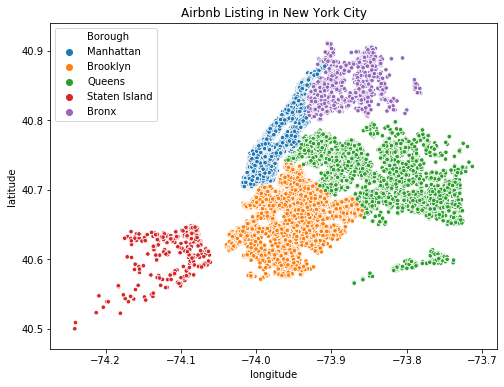

In [448]:
import seaborn as sns
from matplotlib import pyplot as plt
plt.figure(figsize=(8,6))
ax = sns.scatterplot(x='longitude',y='latitude', hue='Borough',s=20, data=airbnb)
ax.set_title('Airbnb Listing in New York City')

#### 2.2 Analyzing the Airbnb Listing Data
##### Count the number of Airbnb Listing in each borough

In [223]:
listing_counts = airbnb['Borough'].value_counts().rename_axis('Borough').to_frame('counts')
listing_counts

counts
Borough              
Manhattan       21963
Brooklyn        19931
Queens           6068
Bronx            1198
Staten Island     370

##### Plot the number of listings in each Borough

Manhattan Borough has the most Airbnb listings.


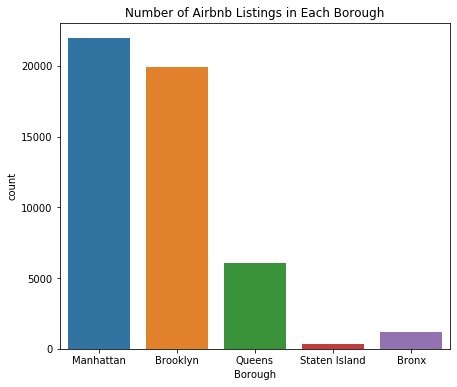

In [224]:
plt.figure(figsize=(7,6))
ax1 = sns.countplot(x='Borough', data=airbnb)
ax1.set_title('Number of Airbnb Listings in Each Borough')

# Add annotation
for p in ax.patches:
    ax.annotate(format(p.get_height(),'.0f'),
               (p.get_x()+p.get_width()/2, p.get_height()+500),
               ha='center',
               va='center',
               )
print('Manhattan Borough has the most Airbnb listings.')

##### The average listing price at each borough

In [225]:
avg_price_borough = airbnb.groupby('Borough', as_index=False)['price'].mean()
avg_price_borough = avg_price_borough.sort_values(by=['price'])
avg_price_borough

Borough       price
0          Bronx   90.176127
3         Queens   99.745056
4  Staten Island  116.908108
1       Brooklyn  125.056194
2      Manhattan  218.855166

##### Plot the average listing price at each borough

Manhattan borough has the highest average airbnb listing price.


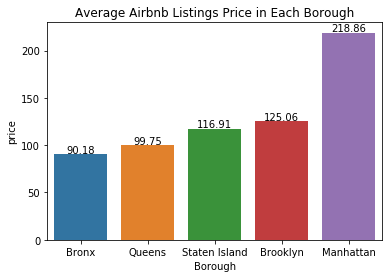

In [226]:
ax2 = sns.barplot(x='Borough', y='price', data=avg_price_borough)
ax2.set_title('Average Airbnb Listings Price in Each Borough')

# Add annotation
for p in ax2.patches:
    ax2.annotate(format(p.get_height(),'.2f'),
               (p.get_x()+p.get_width()/2, p.get_height()+5),
               ha='center',
               va='center',
               )
print('Manhattan borough has the highest average airbnb listing price.')

##### Plot the average Airbnb listing price of each borough using choropleth map

In [255]:
# Download the New York borough boundaries data
with open('Borough Boundaries.geojson') as json_data:
    boundary_data = json.load(json_data)

map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)
map_newyork.choropleth(
    geo_data=boundary_data,
    data=avg_price_borough,
    columns=['Borough','price'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='New York Airbnb Average Listing Price'
)

# display map
map_newyork

#### 2.3 Process Airbnb listing data
##### I want to stay in Manhattan, so first I will filter out the ones that are not in Manhattan

In [230]:
mht_airbnb = airbnb.loc[airbnb['Borough']=='Manhattan']
mht_airbnb.head()

id                                       name  host_id  host_name  \
0  2060                                 Modern NYC     2259      Jenny   
1  2595                      Skylit Midtown Castle     2845   Jennifer   
3  5099  Large Cozy 1 BR Apartment In Midtown East     7322      Chris   
6  5178           Large Furnished Room Near B'way      8967   Shunichi   
7  5203         Cozy Clean Guest Room - Family Apt     7490  MaryEllen   

     Borough        Neighborhood  latitude  longitude        room_type  price  \
0  Manhattan  Washington Heights  40.85722  -73.93790     Private room    100   
1  Manhattan             Midtown  40.75362  -73.98377  Entire home/apt    225   
3  Manhattan         Murray Hill  40.74767  -73.97500  Entire home/apt    200   
6  Manhattan      Hell's Kitchen  40.76489  -73.98493     Private room     79   
7  Manhattan     Upper West Side  40.80178  -73.96723     Private room     79   

   minimum_nights  number_of_reviews last_review  reviews_per_month  \
0               1                  1  2008-09-22               0.01   
1               3                 48  2019-11-04               0.37   
3               3                 78  2019-10-13               0.58   
6               2                473  2020-03-15               3.50   
7               2                118  2017-07-21               0.90   

   calculated_host_listings_count  availability_365  
0                               1               365  
1                               2               335  
3                               1                 0  
6                               1               294  
7                               1                 0

##### Filtering the mht_airbnb data based on following criteria:
+ Price range: 150-500
+ Room type: Entire home/apt
+ Should be availabe
+ Be reviewed at least 5 times
+ Minimum nights = 1

In [236]:
mht_airbnb = mht_airbnb[mht_airbnb['price'] < 500][mht_airbnb['price'] > 150]
mht_airbnb = mht_airbnb[mht_airbnb['room_type']=='Entire home/apt']
mht_airbnb = mht_airbnb[mht_airbnb['availability_365'] != 0]
mht_airbnb = mht_airbnb[mht_airbnb['number_of_reviews'] >= 5]
mht_airbnb = mht_airbnb[mht_airbnb['minimum_nights'] == 1]
mht_airbnb.reset_index(drop=True).head()

id                                        name  host_id host_name  \
0  15711  2 bedroom - Upper East Side-great for kids    61491         D   
1  27385      Great Large 1 BR apt  in East Village!    72062     Bruce   
2  33014                                     NYC Zen   143048     Paula   
3  54544          City Room - Private Penthouse Apt.   256161     Wayne   
4  83391             Huge Studio in Heart of TriBeCa   454497      Lynn   

     Borough     Neighborhood  latitude  longitude        room_type  price  \
0  Manhattan  Upper East Side  40.77065  -73.95269  Entire home/apt    200   
1  Manhattan     East Village  40.72555  -73.97965  Entire home/apt    225   
2  Manhattan     East Village  40.72354  -73.98295  Entire home/apt    195   
3  Manhattan           Harlem  40.81035  -73.94598  Entire home/apt    160   
4  Manhattan          Tribeca  40.72118  -74.01191  Entire home/apt    240   

   minimum_nights  number_of_reviews last_review  reviews_per_month  \
0               1                 82  2020-03-01               0.65   
1               1                124  2020-01-26               1.03   
2               1                 34  2019-08-15               0.29   
3               1                122  2020-01-03               1.06   
4               1                  9  2014-10-06               0.11   

   calculated_host_listings_count  availability_365  
0                               2               296  
1                               4               359  
2                               1               274  
3                               5               362  
4                               1               365

##### Create a new dataframe with only some of the information for further analysis

In [450]:
mht_airbnb = mht_airbnb[['name','host_id','Borough','Neighborhood','latitude','longitude','price']]
mht_airbnb.reset_index(drop=True).head()

name  host_id    Borough  \
0  2 bedroom - Upper East Side-great for kids    61491  Manhattan   
1      Great Large 1 BR apt  in East Village!    72062  Manhattan   
2                                     NYC Zen   143048  Manhattan   
3          City Room - Private Penthouse Apt.   256161  Manhattan   
4             Huge Studio in Heart of TriBeCa   454497  Manhattan   

      Neighborhood  latitude  longitude  price  
0  Upper East Side  40.77065  -73.95269    200  
1     East Village  40.72555  -73.97965    225  
2     East Village  40.72354  -73.98295    195  
3           Harlem  40.81035  -73.94598    160  
4          Tribeca  40.72118  -74.01191    240

In [451]:
mht_airbnb.count()

name            291
host_id         292
Borough         292
Neighborhood    292
latitude        292
longitude       292
price           292
dtype: int64

### 3. Exploring Manhattan
#### 3.1 Obtain the Manhattan neighborhood data from 'neighborhoods'

In [199]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

Borough        Neighborhood   Latitude  Longitude
0  Manhattan         Marble Hill  40.876551 -73.910660
1  Manhattan           Chinatown  40.715618 -73.994279
2  Manhattan  Washington Heights  40.851903 -73.936900
3  Manhattan              Inwood  40.867684 -73.921210
4  Manhattan    Hamilton Heights  40.823604 -73.949688

#### 3.2 Using _geolocator_ to get the geographical location of Manhattan

In [200]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


#### 3.3 Write a function to get the top 100 venues that are in each neighborhood within a radius of 500 meters

In [206]:
# Define Foursquare Credentials and Version
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '' # Foursquare API version

# Write a function to achieve 100 venues within 500 
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

##### Run the above function on each neighborhood and create a new dataframe

In [355]:
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


In [356]:
manhattan_venues.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Marble Hill              40.876551               -73.91066   
1  Marble Hill              40.876551               -73.91066   
2  Marble Hill              40.876551               -73.91066   
3  Marble Hill              40.876551               -73.91066   
4  Marble Hill              40.876551               -73.91066   

                              Venue  Venue Latitude  Venue Longitude  \
0                          Arturo's       40.874412       -73.910271   
1                       Bikram Yoga       40.876844       -73.906204   
2                     Tibbett Diner       40.880404       -73.908937   
3                         Starbucks       40.877531       -73.905582   
4  Astral Fitness & Wellness Center       40.876705       -73.906372   

  Venue Category  
0    Pizza Place  
1    Yoga Studio  
2          Diner  
3    Coffee Shop  
4            Gym

#### 3.4 Analyze each neighborhood

In [357]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

Neighborhood  Accessories Store  Adult Boutique  African Restaurant  \
0  Marble Hill                  0               0                   0   
1  Marble Hill                  0               0                   0   
2  Marble Hill                  0               0                   0   
3  Marble Hill                  0               0                   0   
4  Marble Hill                  0               0                   0   

   American Restaurant  Antique Shop  Arcade  Arepa Restaurant  \
0                    0             0       0                 0   
1                    0             0       0                 0   
2                    0             0       0                 0   
3                    0             0       0                 0   
4                    0             0       0                 0   

   Argentinian Restaurant  Art Gallery  ...  Video Store  \
0                       0            0  ...            0   
1                       0            0  ...            0   
2                       0            0  ...            0   
3                       0            0  ...            0   
4                       0            0  ...            0   

   Vietnamese Restaurant  Volleyball Court  Waterfront  Whisky Bar  Wine Bar  \
0                      0                 0           0           0         0   
1                      0                 0           0           0         0   
2                      0                 0           0           0         0   
3                      0                 0           0           0         0   
4                      0                 0           0           0         0   

   Wine Shop  Wings Joint  Women's Store  Yoga Studio  
0          0            0              0            0  
1          0            0              0            1  
2          0            0              0            0  
3          0            0              0            0  
4          0            0              0            0  

[5 rows x 327 columns]

##### Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [364]:
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped.head()

Neighborhood  Accessories Store  Adult Boutique  African Restaurant  \
0  Battery Park City                0.0             0.0            0.000000   
1      Carnegie Hill                0.0             0.0            0.000000   
2     Central Harlem                0.0             0.0            0.066667   
3            Chelsea                0.0             0.0            0.000000   
4          Chinatown                0.0             0.0            0.000000   

   American Restaurant  Antique Shop  Arcade  Arepa Restaurant  \
0             0.014493           0.0     0.0              0.00   
1             0.010870           0.0     0.0              0.00   
2             0.044444           0.0     0.0              0.00   
3             0.040000           0.0     0.0              0.01   
4             0.030000           0.0     0.0              0.00   

   Argentinian Restaurant  Art Gallery  ...  Video Store  \
0                 0.00000     0.000000  ...          0.0   
1                 0.01087     0.000000  ...          0.0   
2                 0.00000     0.022222  ...          0.0   
3                 0.00000     0.060000  ...          0.0   
4                 0.00000     0.000000  ...          0.0   

   Vietnamese Restaurant  Volleyball Court  Waterfront  Whisky Bar  Wine Bar  \
0                0.00000               0.0         0.0         0.0   0.00000   
1                0.01087               0.0         0.0         0.0   0.01087   
2                0.00000               0.0         0.0         0.0   0.00000   
3                0.00000               0.0         0.0         0.0   0.01000   
4                0.03000               0.0         0.0         0.0   0.00000   

   Wine Shop  Wings Joint  Women's Store  Yoga Studio  
0   0.014493          0.0        0.00000     0.000000  
1   0.032609          0.0        0.01087     0.032609  
2   0.000000          0.0        0.00000     0.000000  
3   0.020000          0.0        0.00000     0.000000  
4   0.000000          0.0        0.00000     0.010000  

[5 rows x 327 columns]

##### Select all columns with Restaurant

In [454]:
col_name = [col for col in manhattan_grouped if "Restaurant" in col]
restaurant = manhattan_grouped[['Neighborhood']+ col_name]
restaurant.head()

Neighborhood  African Restaurant  American Restaurant  \
0  Battery Park City            0.000000             0.014493   
1      Carnegie Hill            0.000000             0.010870   
2     Central Harlem            0.066667             0.044444   
3            Chelsea            0.000000             0.040000   
4          Chinatown            0.000000             0.030000   

   Arepa Restaurant  Argentinian Restaurant  Asian Restaurant  \
0              0.00                 0.00000              0.00   
1              0.00                 0.01087              0.00   
2              0.00                 0.00000              0.00   
3              0.01                 0.00000              0.00   
4              0.00                 0.00000              0.02   

   Australian Restaurant  Austrian Restaurant  Brazilian Restaurant  \
0                    0.0                 0.00                   0.0   
1                    0.0                 0.00                   0.0   
2                    0.0                 0.00                   0.0   
3                    0.0                 0.00                   0.0   
4                    0.0                 0.01                   0.0   

   Cambodian Restaurant  ...  Swiss Restaurant  Szechuan Restaurant  \
0                   0.0  ...               0.0                  0.0   
1                   0.0  ...               0.0                  0.0   
2                   0.0  ...               0.0                  0.0   
3                   0.0  ...               0.0                  0.0   
4                   0.0  ...               0.0                  0.0   

   Taiwanese Restaurant  Tapas Restaurant  Thai Restaurant  Theme Restaurant  \
0                  0.00          0.000000             0.00               0.0   
1                  0.00          0.000000             0.00               0.0   
2                  0.00          0.022222             0.00               0.0   
3                  0.00          0.000000             0.00               0.0   
4                  0.01          0.000000             0.01               0.0   

   Turkish Restaurant  Udon Restaurant  Vegetarian / Vegan Restaurant  \
0                 0.0              0.0                        0.00000   
1                 0.0              0.0                        0.01087   
2                 0.0              0.0                        0.00000   
3                 0.0              0.0                        0.00000   
4                 0.0              0.0                        0.01000   

   Vietnamese Restaurant  
0                0.00000  
1                0.01087  
2                0.00000  
3                0.00000  
4                0.03000  

[5 rows x 73 columns]

#### 3.5 Cluster Neighborhoods
##### Find the best value of k according to Elbow method

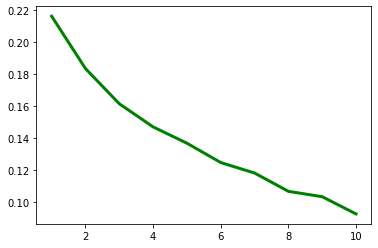

In [456]:
restaurant_clustering = restaurant.drop('Neighborhood', 1)
cost = []
for i in range(1,11):
    KM = KMeans(n_clusters = i, max_iter = 500)
    KM.fit(restaurant_clustering)
    cost.append(KM.inertia_)

plt.plot(range(1,11), cost, color='g',linewidth=3)


##### Run k-means to cluster the neighborhood into 6 clusters

In [457]:
kclusters = 6
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(restaurant_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 3, 2, 2, 5, 3, 3, 1, 4, 2])

##### Create a new dataframe that includes the cluster as well as the restaurants for each neighborhood.

In [458]:
# add clustering labels
restaurant.insert(0, 'Cluster Labels', kmeans.labels_)
restaurant_merged = manhattan_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
restaurant_merged = restaurant_merged.join(restaurant.set_index('Neighborhood'), on='Neighborhood')

restaurant_merged.head()

Borough        Neighborhood   Latitude  Longitude  Cluster Labels  \
0  Manhattan         Marble Hill  40.876551 -73.910660               2   
1  Manhattan           Chinatown  40.715618 -73.994279               5   
2  Manhattan  Washington Heights  40.851903 -73.936900               4   
3  Manhattan              Inwood  40.867684 -73.921210               4   
4  Manhattan    Hamilton Heights  40.823604 -73.949688               4   

   African Restaurant  American Restaurant  Arepa Restaurant  \
0                 0.0             0.038462          0.000000   
1                 0.0             0.030000          0.000000   
2                 0.0             0.010989          0.010989   
3                 0.0             0.035714          0.000000   
4                 0.0             0.000000          0.000000   

   Argentinian Restaurant  Asian Restaurant  ...  Swiss Restaurant  \
0                     0.0              0.00  ...               0.0   
1                     0.0              0.02  ...               0.0   
2                     0.0              0.00  ...               0.0   
3                     0.0              0.00  ...               0.0   
4                     0.0              0.00  ...               0.0   

   Szechuan Restaurant  Taiwanese Restaurant  Tapas Restaurant  \
0                  0.0                  0.00          0.000000   
1                  0.0                  0.01          0.000000   
2                  0.0                  0.00          0.021978   
3                  0.0                  0.00          0.000000   
4                  0.0                  0.00          0.000000   

   Thai Restaurant  Theme Restaurant  Turkish Restaurant  Udon Restaurant  \
0         0.000000               0.0                 0.0              0.0   
1         0.010000               0.0                 0.0              0.0   
2         0.010989               0.0                 0.0              0.0   
3         0.000000               0.0                 0.0              0.0   
4         0.000000               0.0                 0.0              0.0   

   Vegetarian / Vegan Restaurant  Vietnamese Restaurant  
0                           0.00                   0.00  
1                           0.01                   0.03  
2                           0.00                   0.00  
3                           0.00                   0.00  
4                           0.00                   0.00  

[5 rows x 77 columns]

##### Visualize the resulting clusters

In [459]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(restaurant_merged['Latitude'], restaurant_merged['Longitude'], restaurant_merged['Neighborhood'], restaurant_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

##### The neighborhoods in the cluster 4 have the similar restaurants

In [381]:
rest_cluster4 = restaurant_merged.loc[restaurant_merged['Cluster Labels'] == 4,  restaurant_merged.columns[[1] + list(range(5, restaurant_merged.shape[1]))]]
rest_cluster4.reset_index(drop=True)

Neighborhood  African Restaurant  American Restaurant  \
0  Washington Heights                 0.0             0.010989   
1              Inwood                 0.0             0.035714   
2    Hamilton Heights                 0.0             0.000000   
3      Manhattanville                 0.0             0.000000   
4        East Village                 0.0             0.020000   
5    Manhattan Valley                 0.0             0.000000   
6          Tudor City                 0.0             0.013514   

   Arepa Restaurant  Argentinian Restaurant  Asian Restaurant  \
0          0.010989                    0.00          0.000000   
1          0.000000                    0.00          0.000000   
2          0.000000                    0.00          0.000000   
3          0.000000                    0.00          0.000000   
4          0.010000                    0.01          0.000000   
5          0.000000                    0.00          0.000000   
6          0.000000                    0.00          0.013514   

   Australian Restaurant  Austrian Restaurant  Brazilian Restaurant  \
0                    0.0                  0.0                   0.0   
1                    0.0                  0.0                   0.0   
2                    0.0                  0.0                   0.0   
3                    0.0                  0.0                   0.0   
4                    0.0                  0.0                   0.0   
5                    0.0                  0.0                   0.0   
6                    0.0                  0.0                   0.0   

   Cambodian Restaurant  ...  Swiss Restaurant  Szechuan Restaurant  \
0                   0.0  ...              0.00             0.000000   
1                   0.0  ...              0.00             0.000000   
2                   0.0  ...              0.00             0.000000   
3                   0.0  ...              0.00             0.000000   
4                   0.0  ...              0.01             0.000000   
5                   0.0  ...              0.00             0.023256   
6                   0.0  ...              0.00             0.000000   

   Taiwanese Restaurant  Tapas Restaurant  Thai Restaurant  Theme Restaurant  \
0                  0.00          0.021978         0.010989               0.0   
1                  0.00          0.000000         0.000000               0.0   
2                  0.00          0.000000         0.000000               0.0   
3                  0.00          0.000000         0.000000               0.0   
4                  0.01          0.010000         0.000000               0.0   
5                  0.00          0.000000         0.023256               0.0   
6                  0.00          0.000000         0.027027               0.0   

   Turkish Restaurant  Udon Restaurant  Vegetarian / Vegan Restaurant  \
0                 0.0              0.0                           0.00   
1                 0.0              0.0                           0.00   
2                 0.0              0.0                           0.00   
3                 0.0              0.0                           0.00   
4                 0.0              0.0                           0.02   
5                 0.0              0.0                           0.00   
6                 0.0              0.0                           0.00   

   Vietnamese Restaurant  
0               0.000000  
1               0.000000  
2               0.000000  
3               0.000000  
4               0.030000  
5               0.023256  
6               0.027027  

[7 rows x 73 columns]

#### 3.6 Create an Airbnb listing recommendation list

In [461]:
mht_airbnb_rest = mht_airbnb.merge(rest_cluster4, on='Neighborhood')
mht_airbnb_rest = mht_airbnb_rest[['name','host_id','Borough','Neighborhood','latitude','longitude','price']]
mht_airbnb_rest.head()

name  host_id    Borough  Neighborhood  \
0  Great Large 1 BR apt  in East Village!    72062  Manhattan  East Village   
1                                 NYC Zen   143048  Manhattan  East Village   
2    Large Studio - Heart of East Village   462776  Manhattan  East Village   
3           East Village House -- Unique!   272730  Manhattan  East Village   
4      Quiet ST MARK'S PLACE ARTIST'S GEM  5364702  Manhattan  East Village   

   latitude  longitude  price  
0  40.72555  -73.97965    225  
1  40.72354  -73.98295    195  
2  40.72843  -73.98895    159  
3  40.72956  -73.97903    250  
4  40.72739  -73.98815    195

In [462]:
mht_airbnb_rest.count()

name            41
host_id         42
Borough         42
Neighborhood    42
latitude        42
longitude       42
price           42
dtype: int64

##### Since Washington Heights is too far away from the city, we will only keep the airbnb listings in the East Village

In [463]:
ev_airbnb = mht_airbnb_rest[mht_airbnb_rest['Neighborhood'] == 'East Village']
ev_airbnb.head()

name  host_id    Borough  Neighborhood  \
0  Great Large 1 BR apt  in East Village!    72062  Manhattan  East Village   
1                                 NYC Zen   143048  Manhattan  East Village   
2    Large Studio - Heart of East Village   462776  Manhattan  East Village   
3           East Village House -- Unique!   272730  Manhattan  East Village   
4      Quiet ST MARK'S PLACE ARTIST'S GEM  5364702  Manhattan  East Village   

   latitude  longitude  price  
0  40.72555  -73.97965    225  
1  40.72354  -73.98295    195  
2  40.72843  -73.98895    159  
3  40.72956  -73.97903    250  
4  40.72739  -73.98815    195

In [464]:
ev_airbnb.count()

name            31
host_id         32
Borough         32
Neighborhood    32
latitude        32
longitude       32
price           32
dtype: int64

##### Run the getNearbyVenunes function to get the top 100 venues that are around each airbnb listing within a radius of 500 meters

In [398]:
ev_venues = getNearbyVenues(names=ev_airbnb['host_id'],
                            latitudes=ev_airbnb['latitude'],
                            longitudes=ev_airbnb['longitude']
                            )

72062
143048
462776
272730
5364702
7558452
2208993
5048868
1472225
11395220
7558452
1019170
1420868
44862166
47730499
1598283
16419280
40438814
2552603
33827790
166066107
9973967
185981519
11305249
33225521
219558480
2334794
160356
95892016
259066380
1187935
194180502


In [428]:
ev_venues.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0         72062               40.72555               -73.97965   
1         72062               40.72555               -73.97965   
2         72062               40.72555               -73.97965   
3         72062               40.72555               -73.97965   
4         72062               40.72555               -73.97965   

                          Venue  Venue Latitude  Venue Longitude  \
0    Sunny & Annie Gourmet Deli       40.724590       -73.981600   
1  Tompkins Square Park Dog Run       40.726538       -73.981297   
2                   The Wayland       40.725264       -73.978040   
3        Alphabet City Beer Co.       40.723753       -73.979043   
4              Bobwhite Counter       40.723715       -73.979121   

        Venue Category  
0        Deli / Bodega  
1              Dog Run  
2         Cocktail Bar  
3             Beer Bar  
4  Fried Chicken Joint

##### Count the number of venues around each airbnb listing

In [432]:
ev_venue_counts = ev_venues.groupby('Neighborhood').count().reset_index()
ev_venue_counts = ev_venue_counts.rename(columns = {'Neighborhood':'host_id'})
ev_venue_counts.head()

host_id  Neighborhood Latitude  Neighborhood Longitude  Venue  \
0    72062                    100                     100    100   
1   143048                    100                     100    100   
2   160356                    100                     100    100   
3   272730                    100                     100    100   
4   462776                    100                     100    100   

   Venue Latitude  Venue Longitude  Venue Category  
0             100              100             100  
1             100              100             100  
2             100              100             100  
3             100              100             100  
4             100              100             100

##### Filtering out the airbnb listings with less than 100 venues within 500 meters

In [439]:
ev_100_venues = ev_venue_counts[ev_venue_counts['Venue'] == 100]
ev_100_venues.head()

host_id  Neighborhood Latitude  Neighborhood Longitude  Venue  \
0    72062                    100                     100    100   
1   143048                    100                     100    100   
2   160356                    100                     100    100   
3   272730                    100                     100    100   
4   462776                    100                     100    100   

   Venue Latitude  Venue Longitude  Venue Category  
0             100              100             100  
1             100              100             100  
2             100              100             100  
3             100              100             100  
4             100              100             100

##### Create a airbnb listing recommendation list

In [441]:
airbnb_recommendation = ev_airbnb.loc[ev_airbnb['host_id'].isin(ev_100_venues['host_id'])]
airbnb_recommendation

name    host_id    Borough  \
0              Great Large 1 BR apt  in East Village!      72062  Manhattan   
1                                             NYC Zen     143048  Manhattan   
2                Large Studio - Heart of East Village     462776  Manhattan   
3                       East Village House -- Unique!     272730  Manhattan   
4                  Quiet ST MARK'S PLACE ARTIST'S GEM    5364702  Manhattan   
6                    Large 2BR apartment East Village    2208993  Manhattan   
7                 2Br East Village VERY Spacious Apt.    5048868  Manhattan   
8                       East Village Duplex Penthouse    1472225  Manhattan   
9                                                 NaN   11395220  Manhattan   
11                 Woodsy-chic Lofted 1BR, Office, AC    1019170  Manhattan   
12                 Large eclectic studio East Village    1420868  Manhattan   
13                  Quaint 1 Bedroom in Happenin' E.V   44862166  Manhattan   
15                      Cozy, quiet, studio apartment    1598283  Manhattan   
17                    Cozy 1 bedroom, Lower East Side   40438814  Manhattan   
18  Best East Village location St Marks 2 bedroom ...    2552603  Manhattan   
20                    Spacious 3 bedroom in Manhattan  166066107  Manhattan   
21    Cozy & quiet 2 bedroom apt in a great location!    9973967  Manhattan   
22         Modern and spacious 2 bedroom in Manhattan  185981519  Manhattan   
23      Stylish & Tranquil East Village Three Bedroom   11305249  Manhattan   
24     Spacious Centrally Located 1 Bedroom Apartment   33225521  Manhattan   
25                 Stylish bright and newly renovated  219558480  Manhattan   
27  XL 3 bedroom full floor E. Village Apt. Scrubbed!     160356  Manhattan   
28      ST MARKS /heart of EAST VILLAGE sleep up to 8   95892016  Manhattan   
29  Entire 2 bedroom apt in the heart of East Village  259066380  Manhattan   
30   Lower East Side Private entrance 2 bedroom suite    1187935  Manhattan   
31   Live Like a New Yorker in the ❤️ of East Village  194180502  Manhattan   

    Neighborhood  latitude  longitude  price  
0   East Village  40.72555  -73.97965    225  
1   East Village  40.72354  -73.98295    195  
2   East Village  40.72843  -73.98895    159  
3   East Village  40.72956  -73.97903    250  
4   East Village  40.72739  -73.98815    195  
6   East Village  40.72210  -73.98356    420  
7   East Village  40.72815  -73.98059    295  
8   East Village  40.72820  -73.98615    267  
9   East Village  40.73215  -73.98821    200  
11  East Village  40.72312  -73.98255    175  
12  East Village  40.72570  -73.97950    230  
13  East Village  40.72689  -73.98676    199  
15  East Village  40.72926  -73.98377    169  
17  East Village  40.72117  -73.98215    160  
18  East Village  40.72681  -73.98401    190  
20  East Village  40.72193  -73.98162    280  
21  East Village  40.72626  -73.98784    310  
22  East Village  40.72189  -73.98219    260  
23  East Village  40.72499  -73.98867    450  
24  East Village  40.72888  -73.99019    300  
25  East Village  40.72876  -73.98655    187  
27  East Village  40.72530  -73.98401    250  
28  East Village  40.72687  -73.98416    396  
29  East Village  40.72690  -73.97866    173  
30  East Village  40.72548  -73.98349    285  
31  East Village  40.72786  -73.98430    399

#### 3.7 Create map of the airbnb listings in the East Village

In [395]:
# Use geopy to get the latitude and longitude values of East Village
address = 'East Village, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude_ev = location.latitude
longitude_ev = location.longitude
print('The geograpical coordinate of East Village are {}, {}.'.format(latitude_ev, longitude_ev))

The geograpical coordinate of East Village are 40.7292688, -73.9873613.


In [444]:
map_clusters = folium.Map(location=[latitude_ev, longitude_ev], zoom_start=14)

for lat, lon, name, price in zip(airbnb_recommendation['latitude'], airbnb_recommendation['longitude'], airbnb_recommendation['name'], airbnb_recommendation['price']):
    label = folium.Popup(str(name) + ' ,$'+str(price), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7).add_to(map_clusters)

 # Adds tool to the top right
from folium.plugins import MeasureControl
map_clusters.add_child(MeasureControl())
# Measurement ruler icon tool to measure distances in map
from folium.plugins import FloatImage
url = ('https://media.licdn.com/mpr/mpr/shrinknp_100_100/AAEAAQAAAAAAAAlgAAAAJGE3OTA4YTdlLTkzZjUtNDFjYy1iZThlLWQ5OTNkYzlhNzM4OQ.jpg')
FloatImage(url, bottom=5, left=85).add_to(map_clusters)

map_clusters

###### The red dots on the map are the Airbnb listing that match our criteria